# Développer un modèle prédictif pour savoir si un compte sera en défaut le mois suivant

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400



J'importe les données à utiliser. Elles se trouvent dans un fichier Excel.

In [2]:
df = pd.read_excel('default_of_credit_card_clients__courseware_version_1_21_19.xls')

In [3]:
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,798fc410-45c1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,8a8c8f3b-8eb4,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,85698822-43f5,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,0737c11b-be42,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,3b7f77cc-dbc0,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,ecff42d0-bdc6,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,99d1fa0e-222b,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,95cdd3e7-4f24,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,00d03f02-04cd,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [4]:
df.shape

(30000, 25)

In [5]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [6]:
df['ID'].nunique()

29687

## Nettoyage de la dataframe

Selon les informations données, un individu de l'observation est unique avec son ID, mais le nombre d'ID unique est déça du nombre d'individus dans la dataframe. Un nettoyage s'impose dès ici.

In [7]:
id_counts = df['ID'].value_counts()
id_counts.head()

ID
89f8f447-fca8    2
7c9b7473-cc2f    2
90330d02-82d9    2
75938fec-e5ec    2
2a793ecf-05c6    2
Name: count, dtype: int64

In [8]:
id_counts.value_counts()

count
1    29374
2      313
Name: count, dtype: int64

In [9]:
dupe_mask = id_counts == 2

In [10]:
id_counts.index[0:5]

Index(['89f8f447-fca8', '7c9b7473-cc2f', '90330d02-82d9', '75938fec-e5ec',
       '2a793ecf-05c6'],
      dtype='object', name='ID')

In [11]:
dupes_ids = id_counts.index[dupe_mask]
len(dupes_ids)

313

In [12]:
dupes_ids = list(dupes_ids)
len(dupes_ids)

313

Je récupère les trois premiers ID de mon mask booléen pour vérifier leur disponibilité dans la dataframe. Un exemple avant le grand nettoyage

In [13]:
df.loc[df['ID'].isin(dupes_ids[0:3]), :].head(10)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
5033,89f8f447-fca8,320000,2,2,1,32,0,0,0,0,...,169371,172868,150827,8000,8000,5500,6100,6000,5000,0
5133,89f8f447-fca8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15879,7c9b7473-cc2f,90000,2,1,1,29,0,0,0,0,...,27751,20292,14937,2967,2007,1429,1092,412,263,0
15979,7c9b7473-cc2f,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29646,90330d02-82d9,70000,1,2,1,29,0,0,0,0,...,10694,27908,11192,2009,1404,3016,20001,2000,5002,0
29746,90330d02-82d9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
df_zero_mask = df == 0

All permet d'identifier les axes sur lesquels toutes les valeurs sont True

In [15]:
feature_zero_mask = df_zero_mask.iloc[:, 1:].all(axis=1)

In [16]:
sum(feature_zero_mask)

315

In [17]:
df_clean_1 = df.loc[~feature_zero_mask, :].copy()

In [18]:
df_clean_1['ID'].nunique()

29685

## Explorer des valeurs et nettoyage des données

In [19]:
df_clean_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29685 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ID                          29685 non-null  object
 1   LIMIT_BAL                   29685 non-null  int64 
 2   SEX                         29685 non-null  int64 
 3   EDUCATION                   29685 non-null  int64 
 4   MARRIAGE                    29685 non-null  int64 
 5   AGE                         29685 non-null  int64 
 6   PAY_1                       29685 non-null  object
 7   PAY_2                       29685 non-null  int64 
 8   PAY_3                       29685 non-null  int64 
 9   PAY_4                       29685 non-null  int64 
 10  PAY_5                       29685 non-null  int64 
 11  PAY_6                       29685 non-null  int64 
 12  BILL_AMT1                   29685 non-null  int64 
 13  BILL_AMT2                   29685 non-null  int64 


La ligne PAY_1 devrait normalement contenir des int64 aussi

In [20]:
df_clean_1['PAY_1'].head(5)

0     2
1    -1
2     0
3     0
4    -1
Name: PAY_1, dtype: object

Selon <a href="https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients">le dictionnaire de la dataframe</a>, le chiffre 0 ne devrait pas être présent, car il n'est relatif à aucun statut de paiement

In [21]:
df_clean_1['PAY_1'].value_counts()

PAY_1
0                13087
-1                5047
1                 3261
Not available     3021
-2                2476
2                 2378
3                  292
4                   63
5                   23
8                   17
6                   11
7                    9
Name: count, dtype: int64

Deux modalités non documentées sont présentes : 0, -2, 'Not available'. Il faudrait donc commencer à les gérer

In [22]:
valid_pay_1_mask = df_clean_1['PAY_1'] != 'Not available'
valid_pay_1_mask[:5]

0    True
1    True
2    True
3    True
4    True
Name: PAY_1, dtype: bool

In [23]:
sum(valid_pay_1_mask)

26664

Ne sachant pas comment remplacer les 'Not available', je choisis simplement de les supprimer

In [24]:
df_clean_2 = df_clean_1.loc[valid_pay_1_mask, :].copy()

In [25]:
df_clean_2.shape

(26664, 25)

Assuré que les données sont toutes des int, je peux maintenant convertir la colonne en int

In [26]:
df_clean_2['PAY_1'] = df_clean_2['PAY_1'].astype('int64')

## La visualisation des données 

array([[<Axes: title={'center': 'LIMIT_BAL'}>,
        <Axes: title={'center': 'AGE'}>]], dtype=object)

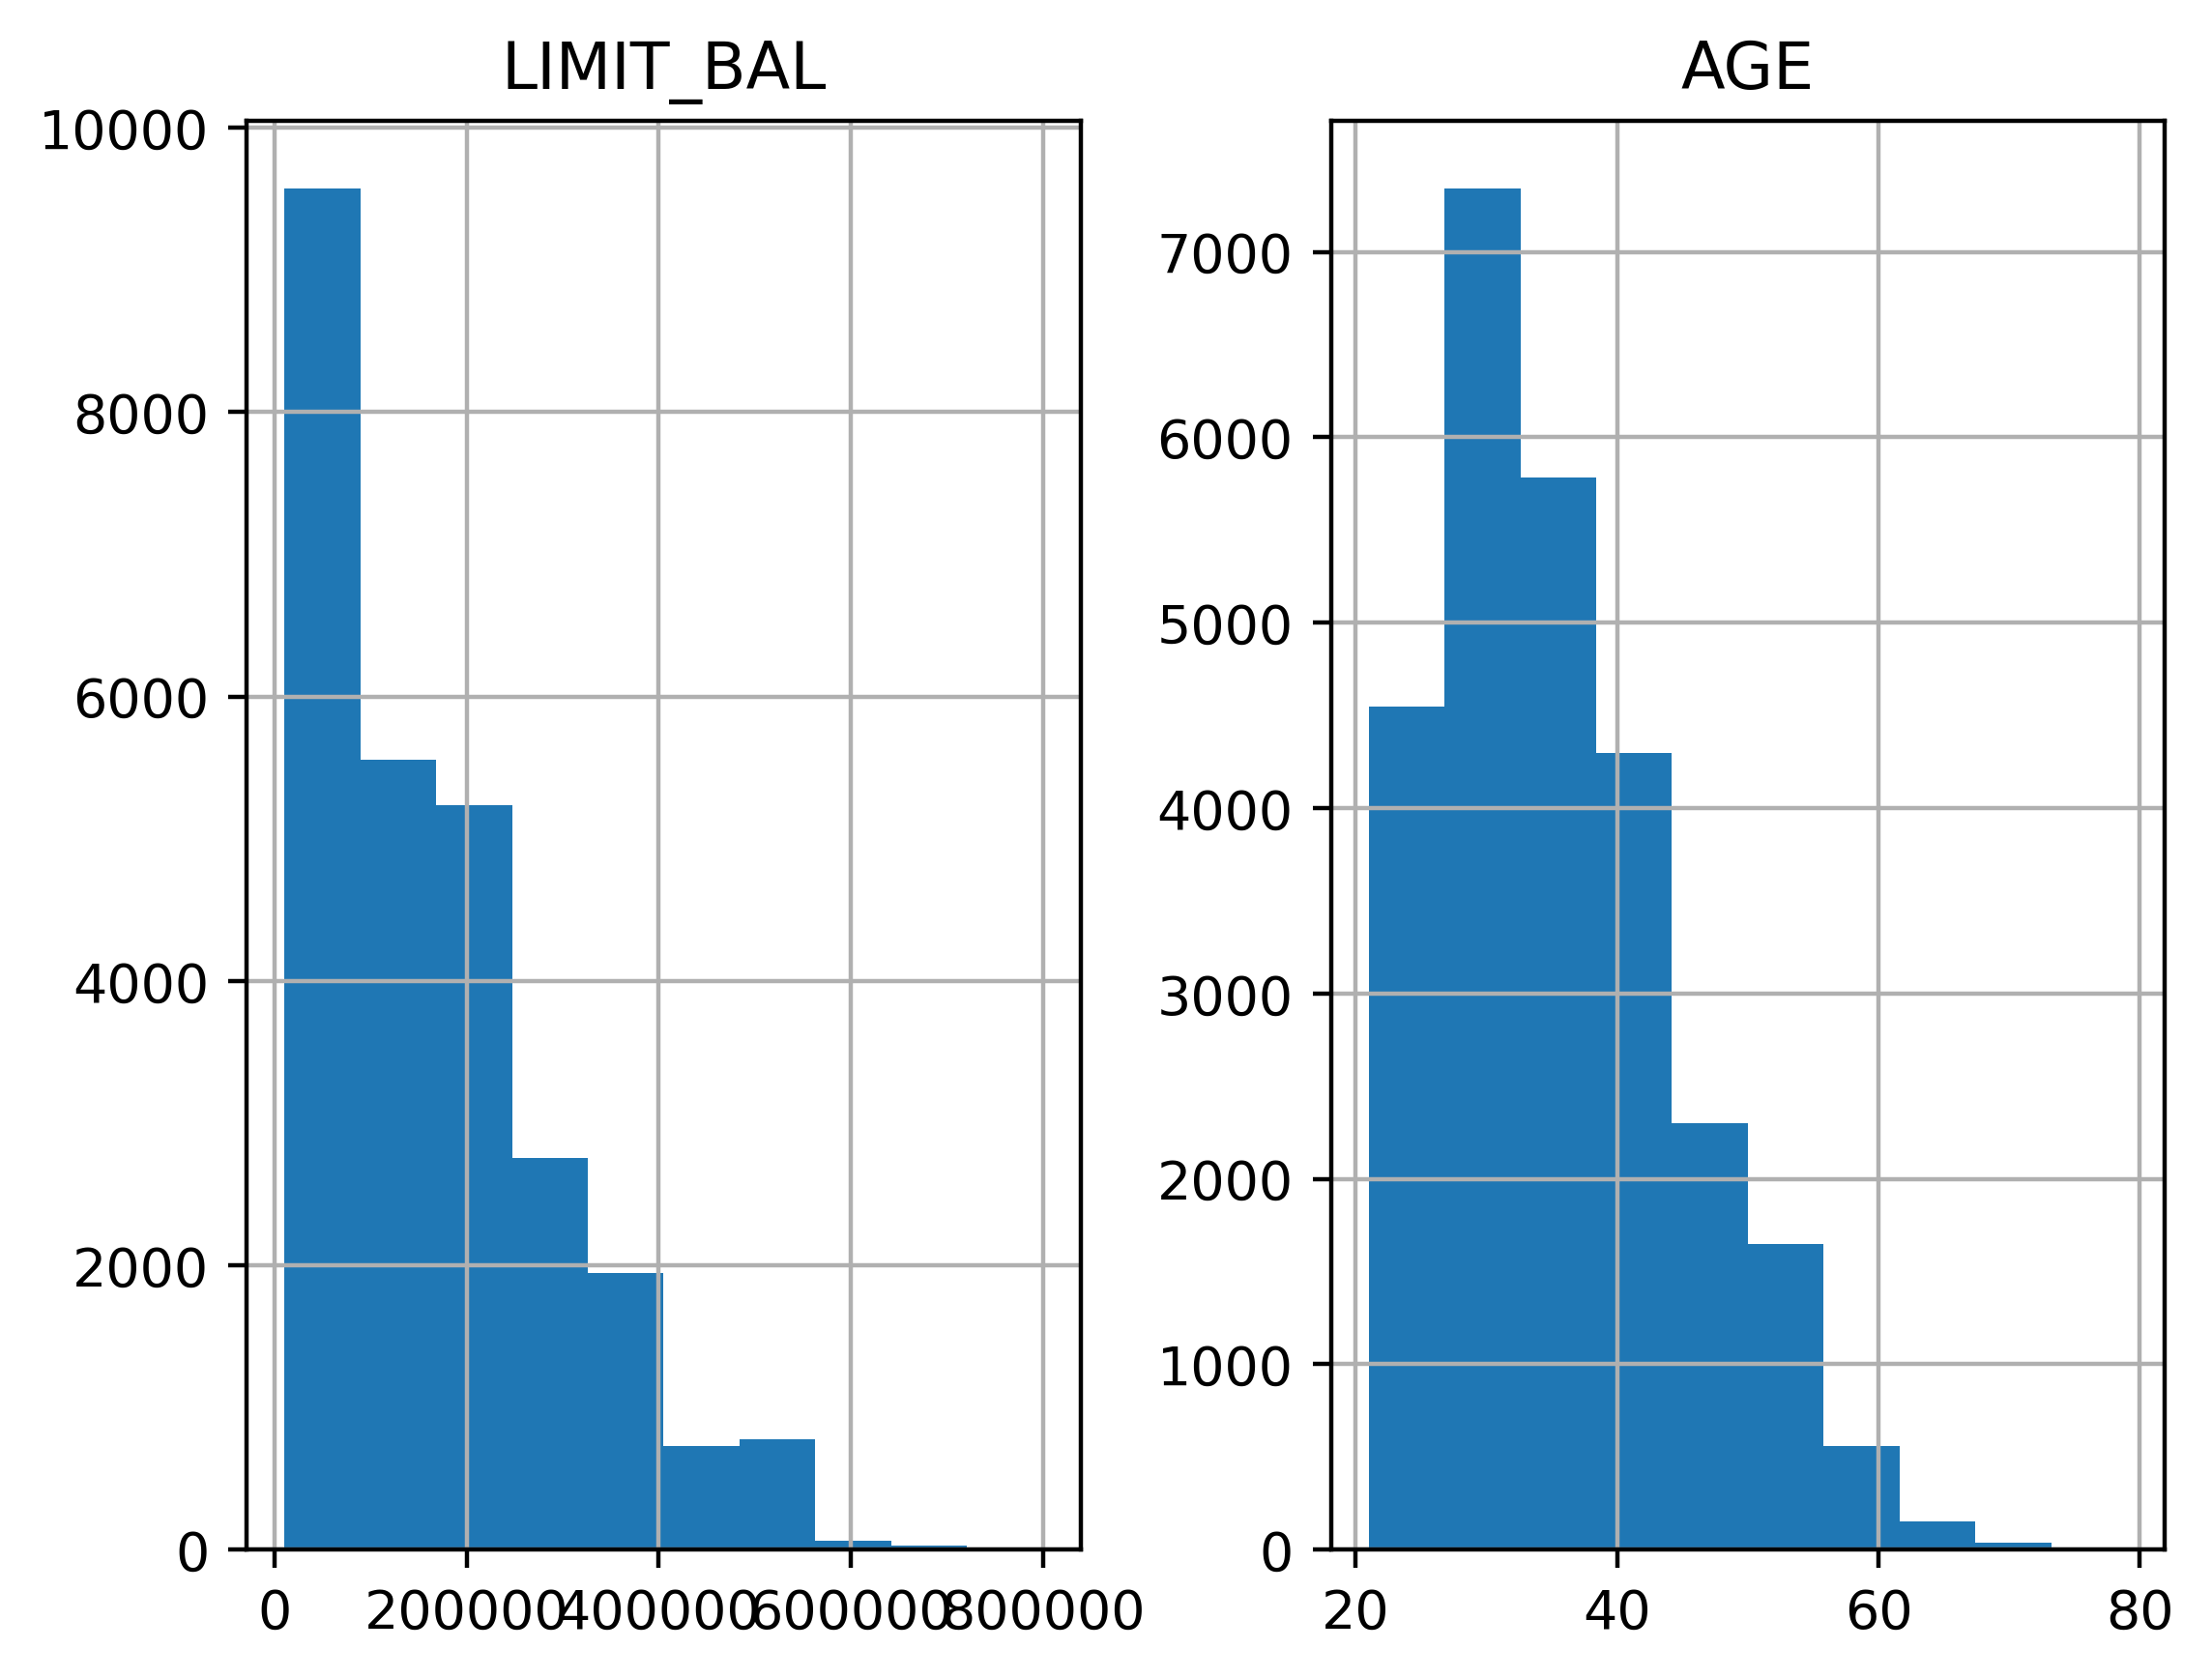

In [32]:
df_clean_2[['LIMIT_BAL', 'AGE']].hist()

In [34]:
df_clean_2[['LIMIT_BAL', 'AGE']].describe()

,LIMIT_BAL,AGE
count,26664.000000,26664.000000
mean,167919.054905,35.505213
std,129839.453081,9.227442
min,10000.000000,21.000000
25%,50000.000000,28.000000
50%,140000.000000,34.000000
75%,240000.000000,41.000000
max,800000.000000,79.000000


Je vois ici des valeurs non présentes dans le dictionnaire : 0, 5, 6
- 1. Graduate school
- 2. University
- 3. High school
- 4. Others

In [35]:
df_clean_2['EDUCATION'].value_counts()

EDUCATION
2    12458
1     9412
3     4380
5      245
4      115
6       43
0       11
Name: count, dtype: int64

Normalement, avec l'accord de mon partenaire, je range toutes les autres valeurs dans autres, comme elles ne sont pas trop répandues

In [39]:
df_clean_2['EDUCATION'].replace(to_replace=[0, 5, 6], value=4)
df_clean_2['EDUCATION'].value_counts()

EDUCATION
2    12458
1     9412
3     4380
4      414
Name: count, dtype: int64

Le 0 qui apparait ici n'est pas documenté dans le dictionnaire

In [40]:
df_clean_2['MARRIAGE'].value_counts()

MARRIAGE
2    14158
1    12172
3      286
0       48
Name: count, dtype: int64

In [43]:
df_clean_2['MARRIAGE'].replace(to_replace=0, value=3)
df_clean_2['MARRIAGE'].value_counts()

MARRIAGE
2    14158
1    12172
3      334
Name: count, dtype: int64

*Les algorithmes de machine learning ne travaillent qu'avec des nombres. Si nous avons des données textuelles, il faudra les traduire d'une manière ou d'une autre en nombre*